In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
pip install pmdarima

In [4]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')  # 경고메시지 숨기기
from keras.optimizers import Adam
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tensorflow import nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm
import pmdarima as pm
from pmdarima.arima import ndiffs

In [5]:
# CSV 파일 로드
file_path = '/content/drive/MyDrive/KDT/환율데이터/저가고가.csv'
df = pd.read_csv(file_path)
df

,DATE,원/달러(저가),원/달러(고가)
0,2021-01-04,1080.3,1087.5
1,2021-01-05,1082.5,1087.9
2,2021-01-06,1084.8,1088.8
3,2021-01-07,1085.7,1089.9
4,2021-01-08,1089.3,1098.9
...,...,...,...
871,2024-07-16,1384.0,1387.3
872,2024-07-17,1379.3,1384.5
873,2024-07-18,1376.5,1382.4
874,2024-07-19,1384.6,1387.7


In [6]:
# 날짜 칼럼 object 형식 --> datetime 형식으로 변환
df['DATE'] = pd.to_datetime(df['DATE'])

df = df.sort_values(by = 'DATE')
df.set_index('DATE', inplace = True)
df

,원/달러(저가),원/달러(고가)
DATE,,
2021-01-04,1080.3,1087.5
2021-01-05,1082.5,1087.9
2021-01-06,1084.8,1088.8
2021-01-07,1085.7,1089.9
2021-01-08,1089.3,1098.9
...,...,...
2024-07-16,1384.0,1387.3
2024-07-17,1379.3,1384.5
2024-07-18,1376.5,1382.4


In [7]:
df['수준변수'] = (df['원/달러(저가)'] + df['원/달러(고가)']) / 2
df['수준변수'] = df['수준변수'].apply(lambda x: float(x))
df = df.drop(['원/달러(저가)', '원/달러(고가)'], axis = 1)
df


,수준변수
DATE,
2021-01-04,1083.90
2021-01-05,1085.20
2021-01-06,1086.80
2021-01-07,1087.80
2021-01-08,1094.10
...,...
2024-07-16,1385.65
2024-07-17,1381.90
2024-07-18,1379.45


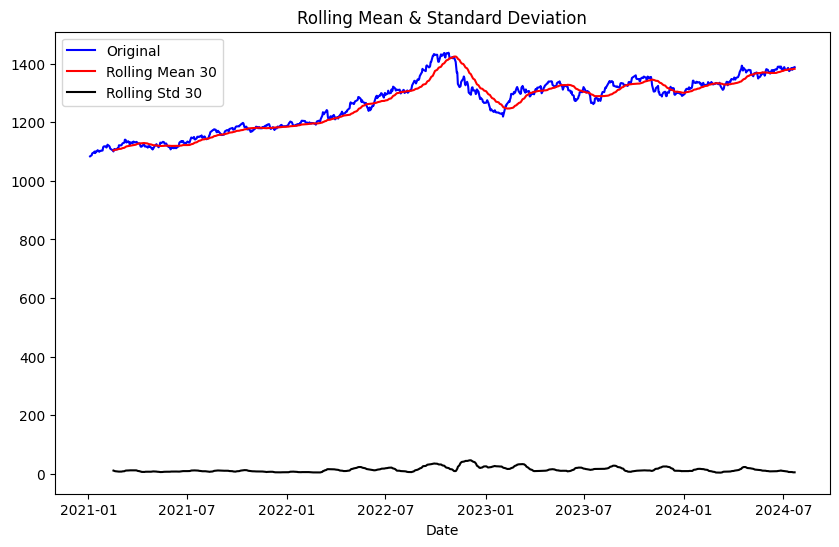

In [8]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# 50일치 평균내어 이동평균계산
plot_rolling(data = df, interval = 30)

In [9]:
from statsmodels.tsa.stattools import adfuller

## ADF
def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(data = df)
#PVALUE > 0.05이상이므로 귀무가설을 기각할수 없음,따라서 환율의 수준변수데이터는 비정상성 데이터이다

ADF TEST 결과
ADF Statistics: -1.478935
p-value: 0.543905
num of lags: 5.000000
num of observations: 870.000000
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


ADF TEST 결과
ADF Statistics: -13.332370
p-value: 0.000000
num of lags: 4.000000
num of observations: 870.000000
Critical values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


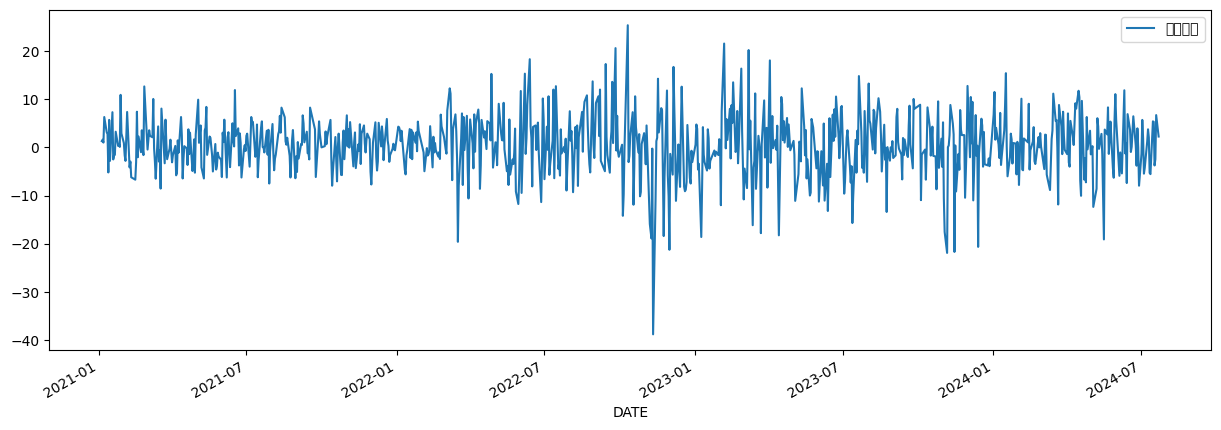

In [10]:
dff1 = df.diff().dropna()
dff1.plot(figsize=(15,5))

# 차분 테이터 adf테스트
print('ADF TEST 결과')
adf_test(dff1)
#pvalue가 0.05미만이므로 가설 기각(채택), 1차 차분 처리한 데이터가 정상성 데이터가 되었다!
#=> 비정상성 데이터는 차분을 이용하여 안정적으로 만들어 분석한다. (ARIMA)

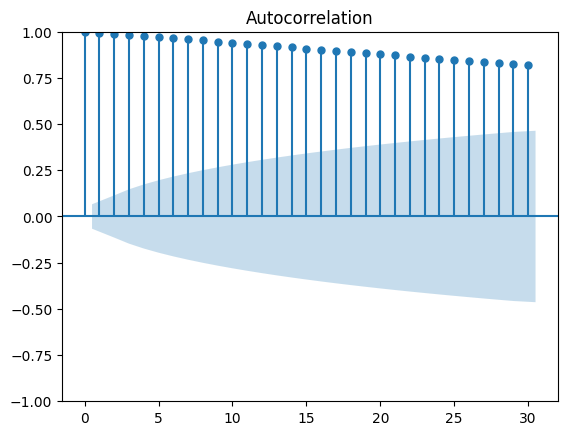

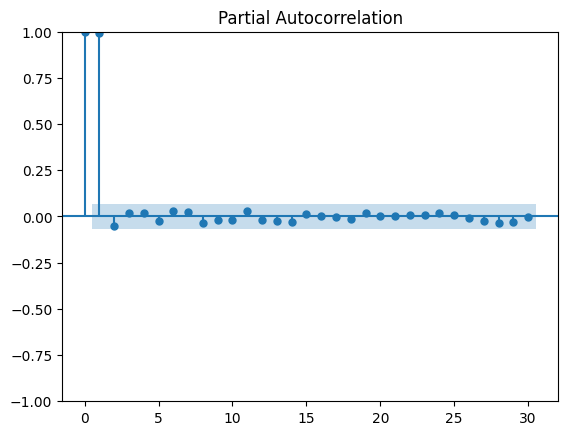

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df)
plot_pacf(df)
plt.show()
#ACF plot가 천천히 감소되는 것으로 보아 환율 데이터는 주기에 따라 일정하지 않은 비정상성 데이터이고,
#PACF plot에서 첫값으로부터 2개 이후 파란 박스에 들어가면서 그래프가 끊기는 것으로 보아 AR(1) 모델을 활용하는 것이 가장 적절할 것으로 예상된다.

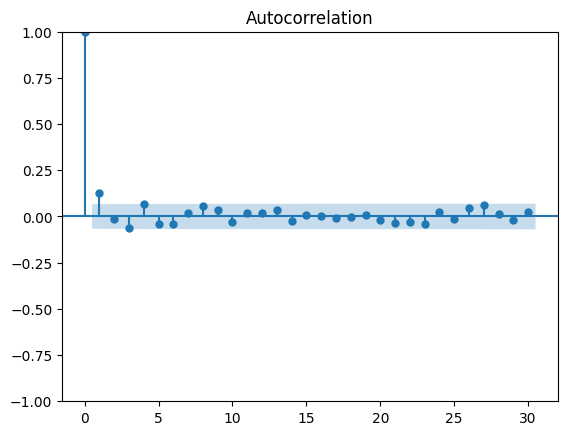

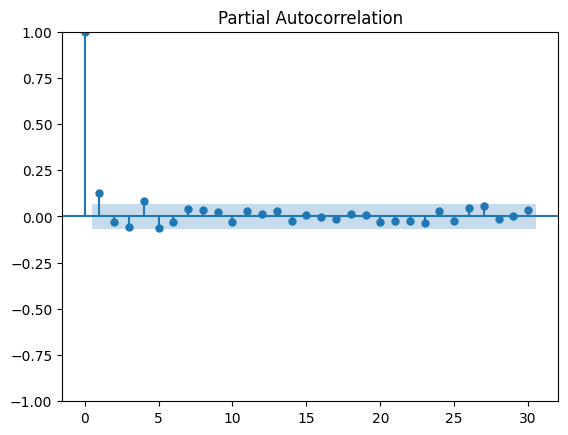

In [12]:
plot_acf(dff1)
plot_pacf(dff1)
plt.show()


In [13]:
df
n_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
print(f"추정된 차수 d = {n_diffs}") # 결과

추정된 차수 d = 1


In [37]:
model = pm.auto_arima(
            y=df,
            d=1,
            start_p=0, max_p=20,
            start_q=0, max_q=20,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5703.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5691.186, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5690.849, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5704.610, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5692.823, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5692.794, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5690.075, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5685.515, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5693.795, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5686.776, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5686.899, Time=1.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5685.908, Time=1.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5688.308, Time=1.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5688.394, Time=4.06 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [15]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  876
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2836.757
Date:                Wed, 24 Jul 2024   AIC                           5685.515
Time:                        01:23:25   BIC                           5714.160
Sample:                             0   HQIC                          5696.472
                                - 876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7804      0.543      1.438      0.150      -0.283       1.844
ar.L1         -0.7840      0.166     -4.717      0.000      -1.110      -0.458
ar.L2         -0.4612      0.130     -3.560      0.0

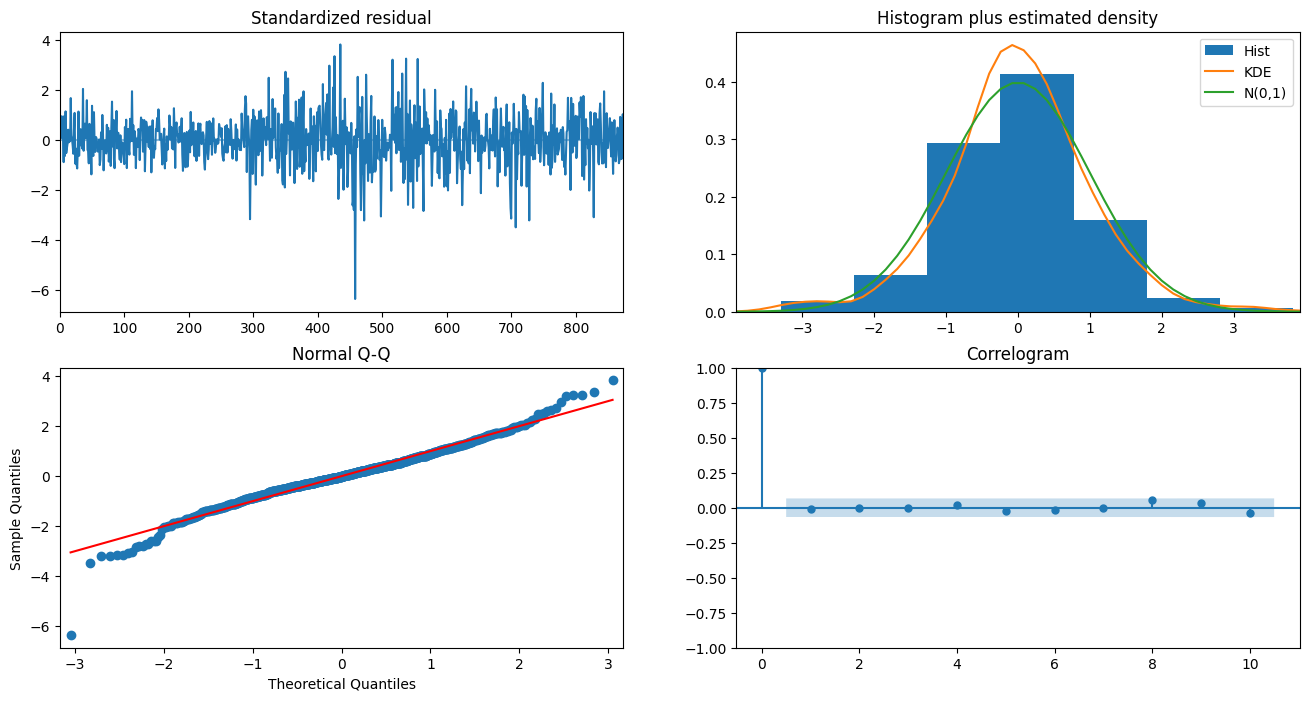

In [38]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [151]:
train_data, test_data = df[:int(len(df)*0.89)], df[int(len(df)*0.89):]

In [152]:
from statsmodels.tsa.arima_model import ARIMA

model_fit = pm.auto_arima(
    	    y=train_data,
 	        d=n_diffs ,
            start_p=0, max_p=2,
            start_q=0, max_q=2,
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)
print(model_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5083.578, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5071.670, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5071.875, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5083.586, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5073.585, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5073.626, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5075.317, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5071.211, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5073.154, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5073.180, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5071.480, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5074.952, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.065 seconds
                               SARIMAX Results                                
Dep. Vari

In [153]:
import numpy as np

def forecast_n_step(model, n=1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    return fc.tolist(), np.asarray(conf_int).tolist()

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data.itertuples():
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob.수준변수)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])

    return pd.Series(y_pred, index=index), pred_upper, pred_lower

DATE
2024-02-29    1334.699003
2024-03-04    1334.527045
2024-03-05    1329.391607
2024-03-06    1333.006954
2024-03-07    1335.600792
                 ...     
2024-07-16    1381.061844
2024-07-17    1386.352056
2024-07-18    1381.405795
2024-07-19    1379.126421
2024-07-22    1387.031553
Length: 97, dtype: float64


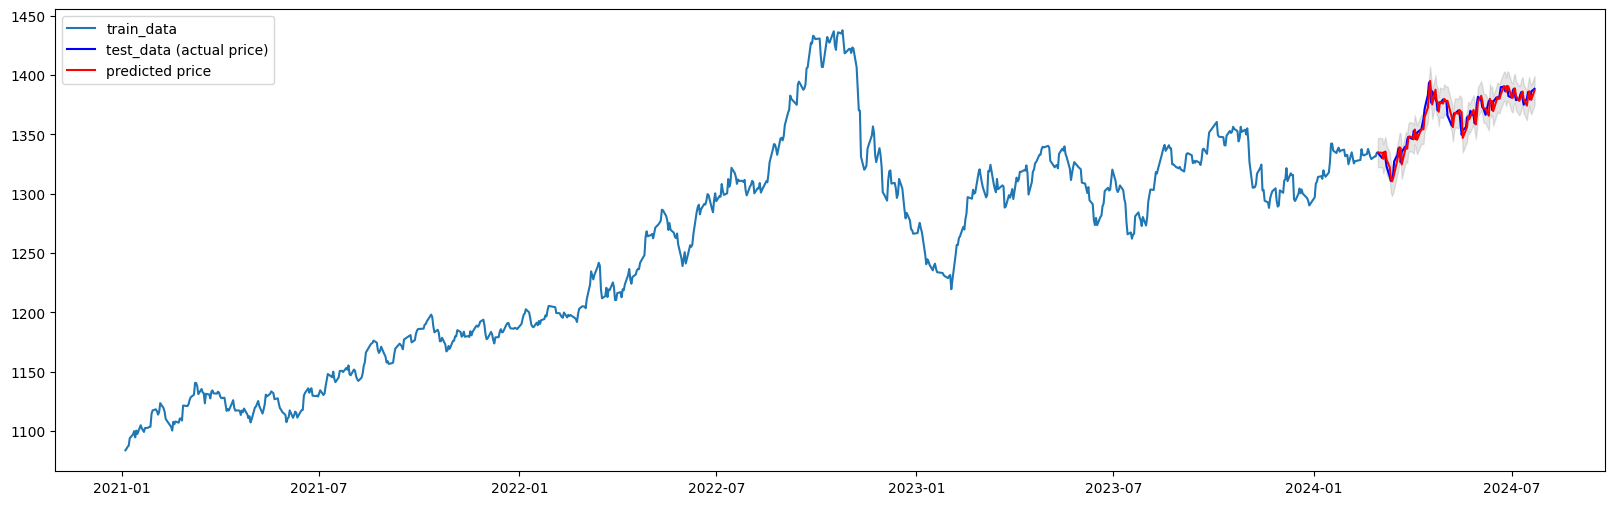

In [154]:
# 예측 수행
fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data=test_data)

# pandas series 생성
fc_series = pd.Series(fc, index=test_data.index)  # 예측결과
lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드


print(fc_series)

# Plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='train_data')
plt.plot(test_data, c='b', label='test_data (actual price)')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend(loc='upper left')
plt.show()

In [155]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(test_data,fc)
print('MSE: ', mse)
mae = mean_absolute_error(test_data,fc)
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(test_data,fc))
print('RMSE: ', rmse)
mape = np.mean(fc- test_data/test_data)
print('MAPE: ' ,'{:.2f}%'.format(mape*100))

MSE:  34.760450903459066
MAE:  4.770836080003722
RMSE:  5.895799428699985
MAPE:  nan%


In [156]:
test_data

,수준변수
DATE,
2024-02-29,1334.50
2024-03-04,1330.00
2024-03-05,1332.65
2024-03-06,1335.25
2024-03-07,1329.60
...,...
2024-07-16,1385.65
2024-07-17,1381.90
2024-07-18,1379.45


In [196]:
df4 = pd.Series()
df4= test_data[-30:]
df4

,수준변수
DATE,
2024-06-11,1377.05
2024-06-12,1377.95
2024-06-13,1370.55
2024-06-14,1377.45
2024-06-17,1381.10
2024-06-18,1380.15
2024-06-19,1380.25
2024-06-20,1383.35
2024-06-21,1389.80


30일 주가
2024-07-23    1388.585596
2024-07-24    1376.116428
2024-07-25    1378.023861
2024-07-26    1369.943410
2024-07-27    1378.012760
2024-07-28    1381.398366
2024-07-29    1380.072379
2024-07-30    1380.258171
2024-07-31    1383.603288
2024-08-01    1390.328074
2024-08-02    1390.178651
2024-08-03    1386.038979
2024-08-04    1390.622712
2024-08-05    1390.245915
2024-08-06    1381.650430
2024-08-07    1380.839639
2024-08-08    1387.115620
2024-08-09    1388.651237
2024-08-10    1382.604896
2024-08-11    1378.452206
2024-08-12    1380.098089
2024-08-13    1384.056818
2024-08-14    1385.967943
2024-08-15    1380.066644
2024-08-16    1374.494842
2024-08-17    1380.791310
2024-08-18    1386.084357
2024-08-19    1381.593404
2024-08-20    1379.249503
2024-08-21    1386.697348
dtype: float64


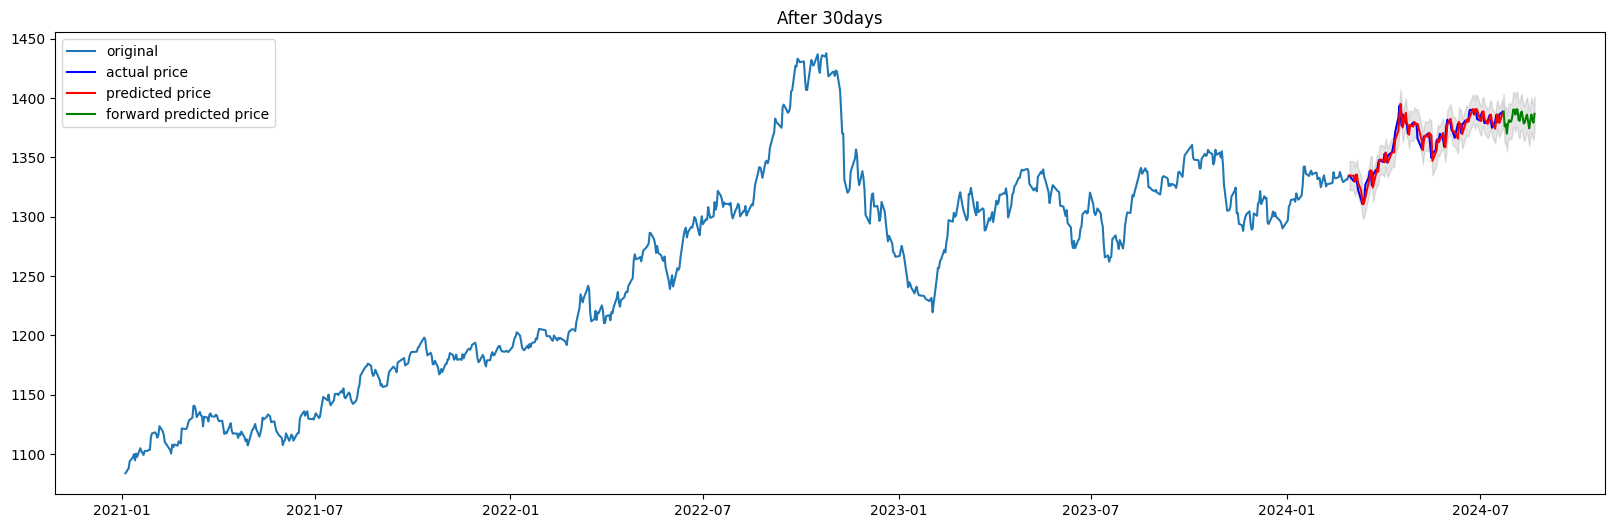

In [198]:
from datetime import datetime, timedelta
#향후 30일 예측

start_date = datetime.strptime('2024-07-23', '%Y-%m-%d')
end_date = start_date + timedelta(days=29)
dates_index = pd.date_range(start=start_date, end=end_date)
dates_index = pd.Series(dates_index)



fc2, upper2, lower2 = forecast(len(dates_index), model_fit, dates_index,df4)
print('30일 주가')
print(fc2)

#fc2, conf = forecast_n_step(model_fit, len(dates_index))
fc2_series = pd.Series(fc2, index=dates_index)  # 예측결과
lower_series2 = pd.Series(lower2, index=dates_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=dates_index)  # 예측결과의 상한 바운드

# plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r',label='predicted price')
plt.plot(fc2, c='g',label='forward predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After 30days')
plt.legend(loc='upper left')
plt.show()

0    2024-08
1    2024-09
2    2024-10
3    2024-11
4    2024-12
5    2025-01
dtype: object
월별 주가
2024-08-01    1388.590119
2024-09-01    1388.606184
2024-10-01    1388.607541
2024-11-01    1388.607656
2024-12-01    1388.607666
2025-01-01    1388.607666
Freq: MS, dtype: float64


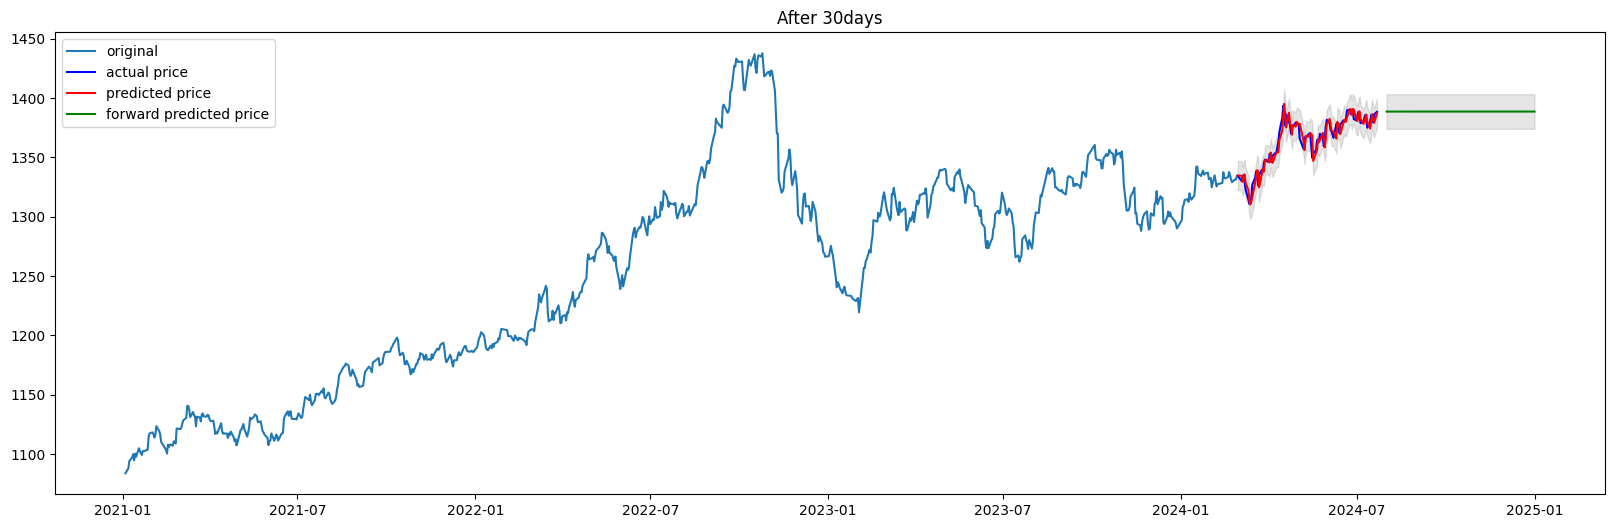

In [168]:
from datetime import datetime, timedelta
#향후 6달 예측

start_date = datetime.strptime('2024-07-23', '%Y-%m-%d')
end_date = start_date + timedelta(days=30)
dates_index = pd.date_range(start=start_date, periods=6, freq='MS')
dates_series = pd.Series(dates_index.strftime('%Y-%m'))
print(dates_series)



fc2, upper2, lower2 = forecast(len(dates_index), model_fit, dates_index)
print('월별 주가')
print(fc2)

#fc2, conf = forecast_n_step(model_fit, len(dates_index))
fc2_series = pd.Series(fc2, index=dates_index)  # 예측결과
lower_series2 = pd.Series(lower2, index=dates_index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(upper2, index=dates_index)  # 예측결과의 상한 바운드

# plot
plt.figure(figsize=(20,6))
plt.plot(train_data, label='original')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc, c='r',label='predicted price')
plt.plot(fc2, c='g',label='forward predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.title('After 30days')
plt.legend(loc='upper left')
plt.show()

In [191]:
'''monthly_mean = fc2.resample('M').mean()
print(monthly_mean)'''

2024-07-31    1332.469898
2024-08-31    1353.889091
2024-09-30    1368.803596
2024-10-31    1382.931176
Freq: M, dtype: float64


In [188]:
'''
#fc3 = fc2.rename(colums = {'0': '수준변수'})
sum_df = pd.concat([df, fc2], axis = 1)
sum_df['수준변수'].fillna(sum_df[0], inplace=True)
sum_df.drop.columns = [0]'''

,수준변수,0
2021-01-04,1083.900000,NaN
2021-01-05,1085.200000,NaN
2021-01-06,1086.800000,NaN
2021-01-07,1087.800000,NaN
2021-01-08,1094.100000,NaN
...,...,...
2024-10-23,1380.808389,1380.808389
2024-10-24,1386.101685,1386.101685
2024-10-25,1381.581234,1381.581234
2024-10-26,1379.241564,1379.241564
